In [15]:
from PIL import Image
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import random
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import VGG16
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
parasitized_dir="parasitized"
uninfected_dir="uninfected"

In [3]:
label_encoder=LabelEncoder()
label_encoder.fit(["uninfected", "parasitized"])
def  preprocessing(dossier, taille=(128,128), pourcentage=0.10):
    images=[]
    labels=[]

    fichiers = os.listdir(dossier)
    nb_images = len(fichiers)
    nb_a_prendre = int(nb_images * pourcentage)
    
    # Sélectionner aléatoirement 25% des images
    fichiers_selectionnes = random.sample(fichiers, nb_a_prendre)
    for fich in fichiers_selectionnes:
        path_image=os.path.join(dossier,fich)
        try:
            image=Image.open(path_image)
            image=image.resize(taille)
            image=np.array(image)
            image=image/255.0
            images.append(image)
            if dossier==uninfected_dir:
                label_encoded = label_encoder.transform(["uninfected"])[0]
                labels.append(label_encoded)
            elif dossier == parasitized_dir:
                label_encoded = label_encoder.transform(["parasitized"])[0]
                labels.append(label_encoded)
        except Exception as e:
                print(f"Erreur lors du chargement de l'image {path_image}: {e}")
    return np.array(images), np.array(labels)

In [4]:
uninfected_img,uninfected_lab=preprocessing(uninfected_dir)

In [5]:
parasitized_img,parasitized_lab=preprocessing(parasitized_dir)

In [6]:
images=np.concatenate((uninfected_img,parasitized_img), axis=0)
labels=np.concatenate((uninfected_lab,parasitized_lab), axis=0)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

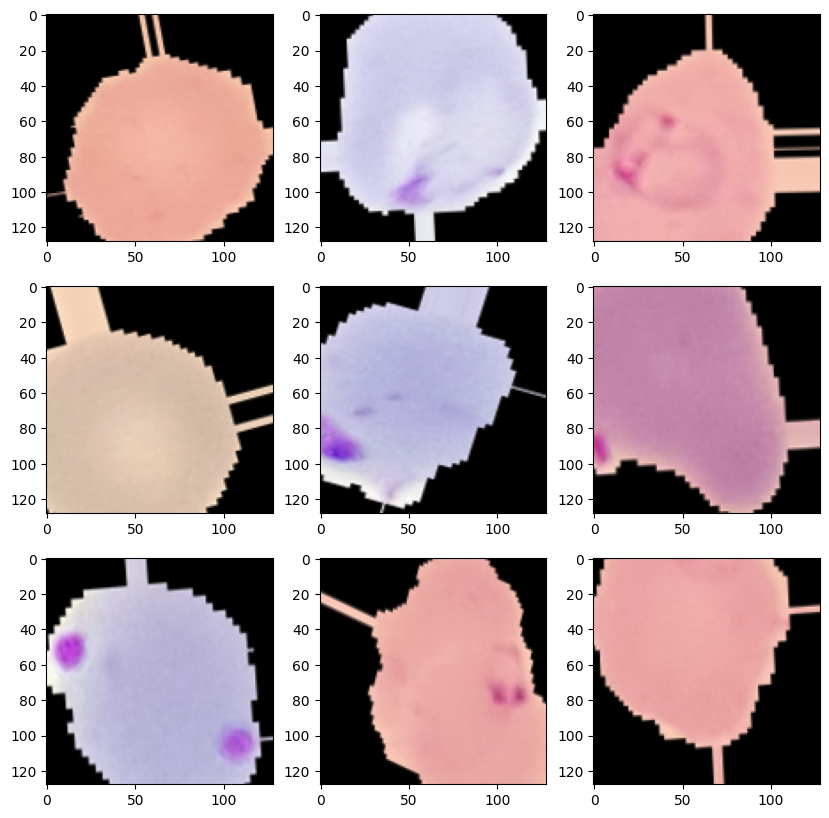

In [10]:
plt.figure(figsize=(10, 10))
i = 0
for batch in datagen.flow(images, batch_size=1):
    plt.subplot(3, 3, i + 1)
    plt.imshow(batch[0])
    i += 1
    if i % 9 == 0:
        break
plt.show()

In [13]:


# Determiner les dimensions (width and height) pour notre preprocessed images
img_height, img_width, channels = images.shape[1:]

# Determiner le npbbre de classes unique depuis encoded labels : 2 classes
num_classes = len(np.unique(label_encoder))

# Vérifier le nbr de classe et le input correcte
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model_1 = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Récupération de l'encodeur pré-entraîné
for layer in model_1.layers:
    layer.trainable = False

# Ajout des couches Dense
x = Flatten()(model_1.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_vgg = Model(inputs=model_1.input, outputs=predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [26]:
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.1, patience=2, monitor='val_loss')
]

model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model_vgg.fit(images, labels, epochs=2, validation_split=0.2, callbacks=callbacks)

Shape des images: (2754, 128, 128, 3)
Shape des labels: (2754,)
Valeurs uniques des labels: [0 1]
Epoch 1/2


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\jorda\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 608, in run_forever

  File "C:\Users\jorda\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1936, in _run_once

  File "C:\Users\jorda\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 84, in _run

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\jorda\AppData\Local\Temp\ipykernel_13752\3563403340.py", line 15, in <module>

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 314, in fit

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 117, in one_step_on_iterator

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 104, in one_step_on_data

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\keras\src\trainers\trainer.py", line 316, in compute_loss

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\keras\src\trainers\compile_utils.py", line 609, in __call__

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\keras\src\trainers\compile_utils.py", line 645, in call

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\keras\src\losses\loss.py", line 43, in __call__

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\keras\src\losses\losses.py", line 22, in call

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\keras\src\losses\losses.py", line 1722, in sparse_categorical_crossentropy

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\keras\src\ops\nn.py", line 1567, in sparse_categorical_crossentropy

  File "c:\Users\jorda\OneDrive\Desktop\MD4\environements\data_env\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 638, in sparse_categorical_crossentropy

Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_8585]